<a href="https://colab.research.google.com/github/kkattt51/ArtInt/blob/main/6_%D0%97%D0%B0%D0%B4%D0%B0%D1%87%D0%B0_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Задача классификации твитов: обучаем рекурентную нейронную сеть на GPU

<font size=2 color=grey> Вдохновлено семинарами по NLP Максима Рябина из BigData Team https://bigdatateam.org/ru

В данном ноутбуке приводится простой пример, как создать неплохую модель классификации твитов с помощью нейронных сетей в фреймворке PyTorch. Внеся всего несколько изменений в первую модель машинного обучения (`Моя первая модель.ipynb`), мы перейдем от задачи регрессии к задаче классификации, и от простой линейной регрессии к целой нейронной сети!

Также мы увидим, насколько гибкими являются алгоритмы машинного обучения, и что они могут быть адаптированы для таких сложно формализуемых задач как работа с текстом. При этом единственное, что нужно, это создать словарь вида "слово" - "числовой индекс" и закодировать им последовательность токенов (слов и знаков препинания): например, 

$$"\text{Мама мыла раму, видишь}" как \text{ } [5, 2, 4, 3, 1]$$

При этом наша модель сама научится искать взаимосвязи между словами и даже понимать некоторую семантику (смысл).

In [ ]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.tokenize import TweetTokenizer

from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

import torch
import torch.nn as nn

import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

### <font color=green> Импортирование данных

Качаем общедоступные данные для задачи классификации токсичных твитов. Выборка представляет собой набор текстов на английском языке и метки классов для различных задач. Нас интересует задача по классификации текстов на "токсичный" или "нет", поэтому будем использовать метку `toxic`.

In [ ]:
!wget -q -nc https://raw.githubusercontent.com/tianqwang/Toxic-Comment-Classification-Challenge/master/data/train.csv

In [ ]:
kaggle_data = pd.read_csv("train.csv")

In [ ]:
kaggle_data.head(2)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0


### <font color=green> Токенизация текстов

Как писалось выше, нужно создать словарь слов и сопоставить словам какие-то числа, а затем "закодировать" последовательность токенов в тексте этими числами. Чтобы это сделать нужно сперва перевести каждый цельный текст в последовательность отдельных слов. Будем использовать `nltk.tokenize.TweetTokenizer`

In [ ]:
tokenizer = TweetTokenizer()
preprocess = lambda text: ' '.join(tokenizer.tokenize(text.lower()))

text = "It's the lecture for Russian Programming School!"
print("До токенизации:", text,)
print("После токенизации:", preprocess(text))

До токенизации: It's the lecture for Russian Programming School!
После токенизации: it's the lecture for russian programming school !


Отделяем целевую метку классов от текстов и формируем списки текстов и их меток после токенизации

In [ ]:
%%time
texts = kaggle_data['comment_text']
target = kaggle_data['toxic']

texts_train, texts_test, y_train, y_test = train_test_split(texts, target, test_size=1000, random_state=42)

texts_train = [preprocess(text) for text in texts_train.tolist()]
texts_test = [preprocess(text) for text in texts_test.tolist()]

CPU times: user 29 s, sys: 172 ms, total: 29.2 s
Wall time: 29.2 s


### <font color=green> Определение словаря

Т.к. фреймворк `PyTorch`, реализующий удобный инструмент обучения нейронных сетей, не обрабатывает каждый конкретный текст отдельно, а сразу вместе, то требуется, чтобы тексты были одинаковой длины. Но к сожалению, в природе тексты встречаются  разной длины, поэтому придется "выровнять" последовательности токенов, добавив токен `<PAD>` к слишком коротким последовательностям. Кроме того, нужно научить модель работать со словами, которые ей не знакомы, для этого вводится ещё один специальный токен `<UNK>`, который будет всегда вставать на место того слова, которое не знакомо модели. Добавляем эти два токена в словарь. Будем формировать словарь с помощью инструмента `sklearn.feature_extraction.text.TfidfVectorizer`, который не только умеет считать tf-idf, но и формировать словари.

In [ ]:
%%time
# создаю инстанс класса векторайзера
tfidf=TfidfVectorizer()
# скармливаю в него обучающую выборку
tfidf.fit(texts_train)

# забираю сформированный словарь
vocab=['<PAD>', '<UNK>']+list(tfidf.vocabulary_.keys())
token_to_index={token:i for i, token in enumerate(vocab)}

CPU times: user 9.57 s, sys: 207 ms, total: 9.78 s
Wall time: 9.78 s


Немного магии: фреймворк `PyTorch` работает не с обычными питоновскими типами данных, а со своим собственным - `torch.tensors`. Класс ниже подготавливает выборку в формате пригодными для `PyTorch`, кодируя последовательности индексами из словаря и создавая тензоры

In [ ]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, texts, labels, vocab):
    self.text_tensors=[]
    self.labels=[]

    for text, label in zip(texts, labels):
      indices = [token_to_index.get(token, 1) for token in text.split()]

      self.text_tensors.append(torch.tensor(indices,dtype=torch.long))
      self.labels.append(label)

    self.lengths=[tensor.size(0) for tensor in self.text_tensors]

  def __len__(self):
    return len(self.text_tensors)

  def __getitem__(self, idx):
    return self.text_tensors[idx], self.lengths[idx], self.labels[idx]

train_dataset=Dataset(texts_train, y_train.values, vocab)
test_dataset=Dataset(texts_test, y_test.values, vocab)

In [ ]:
def collate_fn(samples):
  text_tensors=[]
  lengths=[]
  labels=[]

  for text_tensor, length, label in samples:
    text_tensors.append(text_tensor)
    lengths.append(length)
    labels.append(label)

  padded_tensors = nn.utils.rnn.pad_sequence(text_tensors, padding_value=0, batch_first=True)

  return padded_tensors, torch.tensor(lengths), torch.tensor(labels, dtype=torch.float)

train_loader=torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True, collate_fn=collate_fn, num_workers=4)
test_loader=torch.utils.data.DataLoader(test_dataset, batch_size=512, shuffle=False, collate_fn=collate_fn, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### <font color=green> Задание модели и обучение

Мы подготовили данные, теперь самое время описать модель, функцию потерь, и провести обучение, оптимизируя функцию потерь, по полной аналогии с тем, как мы это делали с первой моделью регрессии, за исключением того, что теперь в качестве данных у нас тексты и предсказываем мы не непрерывную величину, а метку класса (либо токсичный твит, либо нет), а для этого мы на линейную модель сверху накинули функцию активации:

Функция активации принимает в себя выход линейного слоя и затем преобразует значение в число от 0 до 1, которое можно интерпретировать как вероятность токсичности твита, если он токсичный, то (правильное) предсказание модели будет стремиться к единице, если нет - к нулю

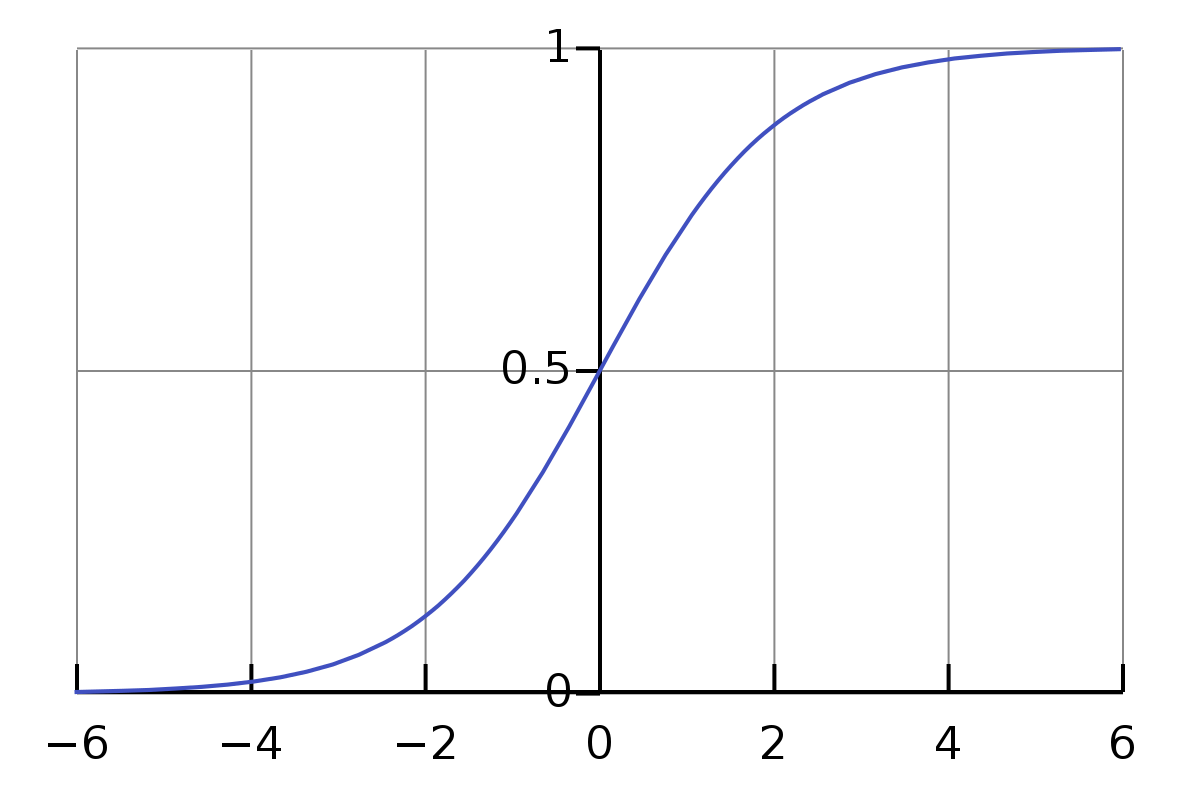

<font color=red size=6>!</font> <font color=red> Чтобы обучать модель на видео-карте, нужно предварительно подцепить её во вкладке `Среда выполнения/Сменить среду выполнения/GPU` в меню Колаба

In [ ]:
!nvidia-smi

Mon May 17 14:28:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# мы будем обучать модель на видеокарте, укажем эту опцию
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Модель обучается на', device)

Модель обучается на cuda


In [ ]:
# описываю модель
class RNNClassifier(torch.nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim):
    super().__init__()
    self.embedding=nn.Embedding(vocab_size, embedding_dim, padding_idx=0) # параметры (num_embeddings, embedding_dim) и индекс, которым
    # небольшое дополнение к знакомой структуре модели:
    # перед линейным слоем будет стоять рекурентный блок, который прогоняет через себя текст
    # и аккумулирует "смысл" текста
    self.rnn=nn.GRU(embedding_dim,hidden_dim,num_layers=1,batch_first=True)
    self.classifier=nn.Linear(hidden_dim, 1)

  def forward(self, inputs, lengths):
    embeddings=self.embedding(inputs)
    packed_inputs=nn.utils.rnn.pack_padded_sequence(embeddings,lengths,
                                        batch_first=True,enforce_sorted=False)
    outputs, final_hiddens = self.rnn(packed_inputs)
    return self.classifier(final_hiddens.view(inputs.size(0),-1))

# создаю экземпляр модели
rnn_model=RNNClassifier(len(vocab),32,32)

# отправлю модель на GPU (видео-карту)
rnn_model.to(device)

RNNClassifier(
  (embedding): Embedding(187367, 32, padding_idx=0)
  (rnn): GRU(32, 32, batch_first=True)
  (classifier): Linear(in_features=32, out_features=1, bias=True)
)

Определяю функцию потерь: это будет логлосс - специальная функция потерь, разработанная для бинарной классификации, она наказывает модель, если та ошибается в своем прогнозе

In [ ]:
criterion = nn.BCEWithLogitsLoss()

Определяю оптимизатор - функцию которая будет делать шаги в сторону минимума функции потерь (логлосса). Будем использовать ту же самую вариацию `Adam`, что и в ноутбуке по предсказанию цены дома с помощью линейной регресии

In [ ]:
optimizer=torch.optim.Adam(rnn_model.parameters(), lr=1e-2)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


CPU times: user 37.6 s, sys: 10.2 s, total: 47.8 s
Wall time: 48.9 s


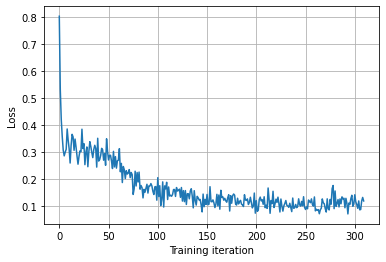

In [ ]:
%%time
torch.manual_seed(0)

NUM_EPOCHS=1
loss_history=[]

rnn_model.train()
for _ in range(NUM_EPOCHS):
  for batch_tokens, batch_lengths, batch_labels in train_loader:
    batch_tokens=batch_tokens.to(device)
    batch_labels=batch_labels.to(device).view(-1,1)

    output=rnn_model(batch_tokens, batch_lengths)
    loss=criterion(output, batch_labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

plt.plot(loss_history)
plt.xlabel('Training iteration')
plt.ylabel('Loss')
plt.grid()

Модель обучилась, можно посмотреть качество предсказания токсичности твита на тестовой выборке

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Accuracy на  train 0.9686638792717458


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Accuracy на  test  0.955


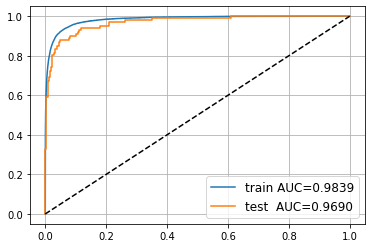

In [ ]:
rnn_model.eval()

for name, loader in [
    ('train', train_loader),
    ('test ', test_loader)
]:
    all_preds=[]
    all_labels=[]
    for batch_tokens, batch_lengths, batch_labels in loader:
      batch_tokens=batch_tokens.to(device)

      with torch.no_grad():
        class_probs=torch.sigmoid(rnn_model(batch_tokens, batch_lengths))
        all_preds.extend(class_probs.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())

    auc = roc_auc_score(all_labels, all_preds)
    accuracy = accuracy_score(all_labels, [1 if x>0.5 else 0 for x in all_preds])
    print('Accuracy на ', name, accuracy)
    plt.plot(*roc_curve(all_labels, all_preds)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

Получили хороший результат - модель правильно обработала 95% тестовых твитов, предсказав верную метку (см. метрику Accuracy). При этом модель не просто неплохо предсказывает токсичность, как таковую, но и умеетнеплохо ранжировать твиты от "наиболее токсичных" к "менее токсичным", проставляю маленькую вероятность "токсичности" хорошим твитам и высокую вероятность плохим.

В домашнем задании вам предстоит построить модель на признаках [Tf-Idf](https://ru.wikipedia.org/wiki/TF-IDF) и сравнить её качество с полученной нами нейросетевой